In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name

conf = (SparkConf().setMaster("k8s://https://192.168.219.100:6443") # Your master address name
        .set("spark.kubernetes.container.image", "joron1827/pyspark:v2") # Spark image name
        .set("spark.driver.port", "2222") # Needs to match svc
        .set("spark.driver.blockManager.port", "7777")
        .set("spark.driver.host", "driver-service.jupyterhub.svc.cluster.local") # Needs to match svc
        .set("spark.driver.bindAddress", "0.0.0.0")
        .set("spark.kubernetes.namespace", "spark")
        .set("spark.kubernetes.authenticate.driver.serviceAccountName", "spark")
        .set("spark.kubernetes.authenticate.serviceAccountName", "spark")
        .set("spark.executor.instances", "4")
        .set("spark.kubernetes.container.image.pullPolicy", "IfNotPresent")
        .set("spark.app.name", "joronSpark")
        .set("spark.executor.cores", "4")
        .set("spark.executor.memory", "16g"))



In [4]:

spark = SparkSession.builder.config(conf=conf).getOrCreate()

import time

time.sleep(10)

In [5]:
save_path = "hdfs://192.168.219.121:9000/crawling_stock_text_merge/text_tokens_label.parquet"

tokenized_df = spark.read.parquet(save_path)
tokenized_df.show()


+------+----------+------------------------------------+----------+----------------------------+
|  code|      date|                               title|New_Column|                      tokens|
+------+----------+------------------------------------+----------+----------------------------+
|005930|2023-04-06|                              여러분|         1|                          []|
|005930|2023-04-06|      나라가  공매도  개망조 들었다 |         1|[나라, 공매도, 개, 망조, ...|
|005930|2023-04-06|       삼성전자 직원 분의  감축 단행|         1|[삼성, 직원, 분, 감축, 단행]|
|005930|2023-04-06|                    분위기 좋고 좋고|         1|        [분위기, 좋고, 좋고]|
|005930|2023-04-06|        삼성전자는 허구한날 왜이래요|         1|  [성, 는, 허구, 한, 날, 요]|
|005930|2023-04-06|                         공매도 전자|         1|                    [공매도]|
|005930|2023-04-06|외국인 선물매도 조 넘은거 처음보는데|         1|[외국인, 선물, 매도, 조, ...|
|005930|2023-04-06|                    순종 못해 망했다|         1|      [순종, 못, 해, 망했다]|
|005930|2023-04-06|                      삼성전자 분기 |       

In [4]:
from pyspark.sql.functions import when

# New_Column 값이 1인 행을 제외하고, 0과 2인 값을 가진 행을 선택하여 새로운 DataFrame 생성
tokenized_df = tokenized_df.filter((tokenized_df.New_Column == 0) | (tokenized_df.New_Column == 2))

# New_Column 값이 2인 경우 1로 변경
tokenized_df = tokenized_df.withColumn("New_Column", when(tokenized_df.New_Column == 2, 1).otherwise(tokenized_df.New_Column))
tokenized_df.show()

+------+----------+------------------------------------+----------+------------------------------+
|  code|      date|                               title|New_Column|                        tokens|
+------+----------+------------------------------------+----------+------------------------------+
|015760|2022-05-30|    이리저리 아무리 생각을 해 보아도|         1|[이리저리, 아무리, 생각, 해...|
|015760|2022-05-30|    이리저리 아무리 생각을 해 보아도|         1|[이리저리, 아무리, 생각, 해...|
|015760|2022-05-30|                  최순실때 만 갔으니|         1|    [최, 순, 실때, 만, 갔으니]|
|015760|2022-05-30|어디에도 전기요금 동결 이야기 없는데|         1|[에도, 전기요금, 동결, 이야...|
|015760|2022-05-30|                    매출은 오르는데 |         1|          [매출, 은, 오르는데]|
|015760|2022-05-30|                         당분간 하락|         1|                [당분간, 하락]|
|015760|2022-05-30|         죄인이처럼 나라 망치지 말자|         1|  [죄인, 처럼, 나라, 망치, ...|
|015760|2022-05-30|              공매도 배 증가전날대비|         1|[공매도, 배, 증가, 전날, 대비]|
|015760|2022-05-30|                   오늘 용돈 받았다 |         1|     

+------+------+
|code  |count |
+------+------+
|008930|34078 |
|074610|177066|
|100090|27385 |
|011690|11710 |
|011930|99120 |
|009830|165706|
|000020|80445 |
|010820|54389 |
|013570|10990 |
|002630|42588 |
|006980|21811 |
|033250|26475 |
|006380|10077 |
|336370|17547 |
|001060|26895 |
|012690|51741 |
|000520|23097 |
|019170|931209|
|001360|127742|
|001440|153849|
+------+------+
only showing top 20 rows



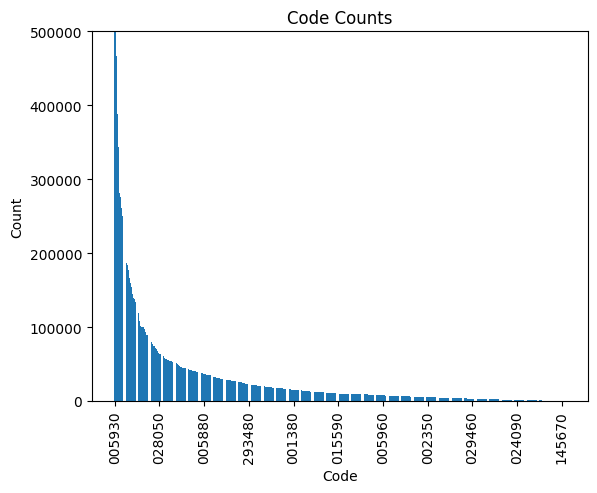

In [10]:
from pyspark.sql.functions import count

# 코드별로 행의 개수 세기
code_counts = tokenized_df.groupBy('code').agg(count('*').alias('count'))

# 결과 출력
code_counts.show(truncate=False)

code_counts_pandas = code_counts.toPandas()


import matplotlib.pyplot as plt

# 내림차순으로 정렬
sorted_code_counts = code_counts_pandas.sort_values('count', ascending=False)

# 히스토그램 그리기
plt.bar(sorted_code_counts['code'], sorted_code_counts['count'])
plt.xlabel('Code')
plt.ylabel('Count')
plt.title('Code Counts')

# x축 레이블 설정
num_ticks = 10  # 표기할 x축 레이블 개수
step = len(sorted_code_counts) // num_ticks
x_ticks = sorted_code_counts.iloc[::step]['code']  # 일정 간격으로 x축 레이블 선택
plt.xticks(x_ticks, rotation=90)

# y축 범위 설정
max_count = sorted_code_counts['count'].max()  # 최대 count 값
plt.ylim(0, 500000)  # 0부터 최대 count 값까지의 범위로 설정

plt.show()


In [7]:
from pyspark.sql.functions import col, row_number
from pyspark.sql import Window

# 라벨 컬럼의 이름
label_column = "New_Column"

# 코드별 데이터 개수 확인
code_counts = tokenized_df.groupBy("code").count()

# 최소 데이터 개수 확인
min_count = code_counts.agg({"count": "min"}).collect()[0][0]
target_count = min_count * 200    # 최소 개수의 절반을 유지하고자 함

# 최소 개수의 절반 이상을 유지하도록 샘플링
window_spec = Window.partitionBy("code").orderBy("date")  # date 컬럼을 기준으로 정렬
balanced_df = tokenized_df.withColumn("row_num", row_number().over(window_spec)).where(col("row_num") <= target_count).drop("row_num")

# 각 코드별로 샘플링된 데이터 개수 확인
balanced_counts = balanced_df.groupBy(label_column).count().collect()

# 결과 출력
for row in balanced_counts:
    label = row[label_column]
    count = row["count"]
    print(f"Label: {label}, Count: {count}")

    
from pyspark.sql.functions import count

# 코드별로 행의 개수 세기
code_counts = balanced_df.groupBy('code').agg(count('*').alias('count'))

# 결과 출력
code_counts.show(truncate=False)



Label: 1, Count: 92779
Label: 0, Count: 51847


+------+-----+
|code  |count|
+------+-----+
|000020|200  |
|000040|200  |
|000050|49   |
|000070|131  |
|000075|5    |
|000080|200  |
|000087|14   |
|000100|200  |
|000105|113  |
|000120|193  |
|000140|33   |
|000145|200  |
|000150|200  |
|000155|200  |
|000157|50   |
|000180|175  |
|000210|200  |
|000215|40   |
|000220|200  |
|000225|200  |
+------+-----+
only showing top 20 rows



In [8]:
from pyspark.sql.functions import col

# 코드 알려주시면 코드에 맞게 조정 가능합니다.
code_column = "code"
label_column = "New_Column"

# 라벨별로 데이터 개수를 확인합니다.
label_counts = balanced_df.groupBy(label_column).count().collect()
label_counts = {row[label_column]: row["count"] for row in label_counts}

# 가장 적은 개수의 데이터를 기준으로 샘플링 비율을 설정합니다.
min_count = min(label_counts.values())
sampling_rates = {label: min_count / count for label, count in label_counts.items()}

# 샘플링 비율을 기준으로 데이터를 샘플링합니다.
sampled_df = balanced_df.sampleBy(label_column, fractions=sampling_rates, seed=42)

# 샘플링된 데이터를 확인합니다.
sampled_df.show()


from pyspark.sql.functions import col

# 라벨 컬럼의 이름
label_column = "New_Column"

# 각 라벨별로 샘플링된 데이터 개수를 확인
sampled_counts = sampled_df.groupBy(label_column).count().collect()

# 결과 출력
for row in sampled_counts:
    label = row[label_column]
    count = row["count"]
    print(f"Label: {label}, Count: {count}")

+------+----------+--------------------------------------+----------+------------------------------+
|  code|      date|                                 title|New_Column|                        tokens|
+------+----------+--------------------------------------+----------+------------------------------+
|000020|2017-06-09|                          이게 뭡니까 |         1|                [게, 뭡, 니까]|
|000020|2017-09-01|                           불개미 비상|         1|                [불개미, 비상]|
|000020|2017-11-23|                                  나도|         1|                        [나도]|
|000020|2017-11-23|                  지금 다 파시는분들은|         1|  [지금, 다, 파시, 는, 분, 은]|
|000020|2017-11-23|                   기간조정 구간입니다|         1|    [기간, 조정, 구간, 입니다]|
|000020|2017-12-13|                    징글징글허다  동화|         0|        [징글징글, 허다, 동화]|
|000020|2017-12-26|                    애처롭기 짝이 없군|         0|          [애처롭기, 짝, 없군]|
|000020|2018-05-14|         이회사는 이사 수집이 취미인가|         0|  [회사, 는, 이사, 수집, 취...|

Label: 1, Count: 51992
Label: 0, Count: 51847


In [9]:
from pyspark.sql.functions import count

# 코드별로 행의 개수 세기
code_counts = sampled_df.groupBy('code').agg(count('*').alias('count'))

# 결과 출력
code_counts.show(truncate=False)

+------+-----+
|code  |count|
+------+-----+
|000020|123  |
|000040|146  |
|000050|36   |
|000070|102  |
|000075|2    |
|000080|160  |
|000087|9    |
|000100|152  |
|000105|62   |
|000120|174  |
|000140|22   |
|000145|118  |
|000150|166  |
|000155|118  |
|000157|40   |
|000180|137  |
|000210|123  |
|000215|23   |
|000220|126  |
|000225|107  |
+------+-----+
only showing top 20 rows



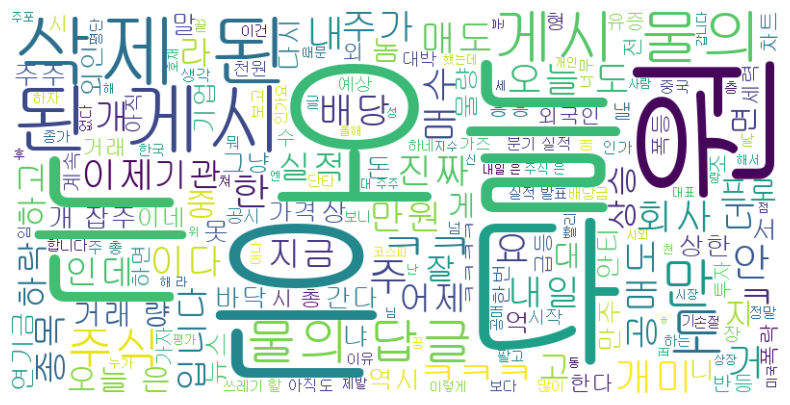

In [10]:
"/home/jovyan/"

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import font_manager

# 한글 폰트 경로 및 이름 지정
font_path = "/home/jovyan/gulim.ttc" # 실제 폰트 파일의 경로로 수정
font_name = "gulim.ttc"  # 설치된 폰트의 이름으로 수정

# WordCloud에 한글 폰트 적용
font_manager.fontManager.addfont(font_path)
plt.rcParams["font.family"] = font_name


import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql.functions import collect_list

# 데이터프레임에서 문자열 컬럼 추출
text_data = sampled_df.filter(sampled_df.New_Column == 0).select("tokens").rdd.flatMap(lambda x: x[0]).collect()

# 문자열 데이터를 공백으로 결합하여 단일 문자열 생성
text = " ".join(text_data)

# WordCloud 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color="white").generate(text)

# WordCloud를 plot으로 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

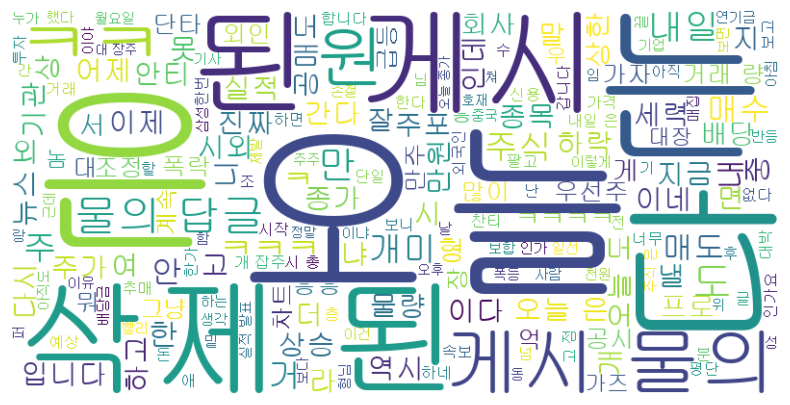

In [11]:
"/home/jovyan/"

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import font_manager

# 한글 폰트 경로 및 이름 지정
font_path = "/home/jovyan/gulim.ttc" # 실제 폰트 파일의 경로로 수정
font_name = "gulim.ttc"  # 설치된 폰트의 이름으로 수정

# WordCloud에 한글 폰트 적용
font_manager.fontManager.addfont(font_path)
plt.rcParams["font.family"] = font_name


import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql.functions import collect_list

# 데이터프레임에서 문자열 컬럼 추출
text_data = sampled_df.filter(sampled_df.New_Column == 1).select("tokens").rdd.flatMap(lambda x: x[0]).collect()

# 문자열 데이터를 공백으로 결합하여 단일 문자열 생성
text = " ".join(text_data)

# WordCloud 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color="white").generate(text)

# WordCloud를 plot으로 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [32]:
## 중복열 제거
## 최빈도 단어 제거
## tfidf 만약 max_df와 같은 기능을 적용하고 싶다면, 스파크에서 직접 해당 기능을 구현해야 합니다. 
## 예를 들어, pyspark.ml.feature.CountVectorizer를 사용하여 단어의 빈도를 계산한 다음, 
## 해당 단어의 빈도가 일정 값 이상인 경우 필터링하는 작업을 추가할 수 있습니다. 이후에 IDF를 적용하여 역문서 빈도를 계산합니다.
## null 값 제거
## 로지스틱, 의사결정트리, SVM, 랜덤포레스트, multinomial NB 

In [6]:
from pyspark.sql.functions import explode, col, array_except, array, lit, udf
from pyspark.sql.types import ArrayType, StringType

# 단어별 빈도수 계산
word_counts = tokenized_df.select(explode('tokens').alias('word')).groupBy('word').count()

# 빈도수로 내림차순 정렬하여 상위 30개 단어 추출
top_words = word_counts.orderBy(col('count').desc()).limit(30)

# 상위 30개 단어 리스트 추출
top_words_list = [row.word for row in top_words.collect()]

print(top_words_list)
# Define the UDF to filter out words in top_words_list
filter_words = udf(lambda tokens: [word for word in tokens if word not in top_words_list], ArrayType(StringType()))

# Add a new column 'filtered_tokens' with only the words present in top_words_list
filtered_df = tokenized_df.withColumn('filtered_tokens', filter_words(col('tokens')))

filtered_df.show()


['은', '오늘', '는', '다', '도', '주', '만', '원', '된', '삭제', '게시', '물의', '한', '주식', '매수', '답글', '개미', 'ㅋㅋ', '고', '개', '안', '상', '라', '대', '내일', '만원', '내', '요', '시', '이다']


+------+----------+------------------------------------+----------+----------------------------+----------------------------+
|  code|      date|                               title|New_Column|                      tokens|             filtered_tokens|
+------+----------+------------------------------------+----------+----------------------------+----------------------------+
|005930|2023-04-06|                              여러분|         1|                          []|                          []|
|005930|2023-04-06|      나라가  공매도  개망조 들었다 |         1|[나라, 공매도, 개, 망조, ...|[나라, 공매도, 망조, 들었다]|
|005930|2023-04-06|       삼성전자 직원 분의  감축 단행|         1|[삼성, 직원, 분, 감축, 단행]|[삼성, 직원, 분, 감축, 단행]|
|005930|2023-04-06|                    분위기 좋고 좋고|         1|        [분위기, 좋고, 좋고]|        [분위기, 좋고, 좋고]|
|005930|2023-04-06|        삼성전자는 허구한날 왜이래요|         1|  [성, 는, 허구, 한, 날, 요]|              [성, 허구, 날]|
|005930|2023-04-06|                         공매도 전자|         1|                    [공매도]|            

In [5]:
filtered_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- date: date (nullable = true)
 |-- title: string (nullable = true)
 |-- New_Column: integer (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import font_manager

# 한글 폰트 경로 및 이름 지정
font_path = "/home/jovyan/gulim.ttc" # 실제 폰트 파일의 경로로 수정
font_name = "gulim.ttc"  # 설치된 폰트의 이름으로 수정

# WordCloud에 한글 폰트 적용
font_manager.fontManager.addfont(font_path)
plt.rcParams["font.family"] = font_name


import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql.functions import collect_list

# 데이터프레임에서 문자열 컬럼 추출
text_data = filtered_df.select("filtered_tokens").rdd.flatMap(lambda x: x[0]).collect()

# 문자열 데이터를 공백으로 결합하여 단일 문자열 생성
text = " ".join(text_data)

# WordCloud 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color="white").generate(text)

# WordCloud를 plot으로 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

----------------------------------------                                        
Exception occurred during processing of request from ('127.0.0.1', 47812)


In [7]:
filtered_df = filtered_df.dropDuplicates(["title","tokens"])
filtered_df.show()
filtered_df.count()

+------+----------+----------------------------+----------+----------------------------+----------------------------+
|  code|      date|                       title|New_Column|                      tokens|             filtered_tokens|
+------+----------+----------------------------+----------+----------------------------+----------------------------+
|013700|2020-01-29|                         ...|         1|                        [쌩]|                        [쌩]|
|034730|2023-02-15|                         ...|         1|                [치는, 회사]|                [치는, 회사]|
|005690|2018-06-10|                         ...|         1|                    [파미셀]|                    [파미셀]|
|066570|2020-10-14|                        매동|         1|                        [동]|                        [동]|
|092220|2018-08-26|                       잠...|         1|                [들렸다, 팁]|                [들렸다, 팁]|
|095720|2019-12-30|                 업종비교...|         1|          [업종, 비교, 최저]|       

20460078

In [9]:
from pyspark.sql.types import BooleanType


# UDF 정의
def is_empty_string(value):
    return len(value) == 0

# UDF 등록
is_empty_string_udf = udf(is_empty_string, BooleanType())

# filtered_tokens 컬럼의 빈 문자열을 결측치로 간주하여 제거
df_filtered = filtered_df.filter(~is_empty_string_udf(col("filtered_tokens")))

# 결과 출력
df_filtered.show()
df_filtered.count()
df_filtered.printSchema()




+------+----------+----------------------------+----------+----------------------------+----------------------------+
|  code|      date|                       title|New_Column|                      tokens|             filtered_tokens|
+------+----------+----------------------------+----------+----------------------------+----------------------------+
|013700|2020-01-29|                         ...|         1|                        [쌩]|                        [쌩]|
|034730|2023-02-15|                         ...|         1|                [치는, 회사]|                [치는, 회사]|
|005690|2018-06-10|                         ...|         1|                    [파미셀]|                    [파미셀]|
|066570|2020-10-14|                        매동|         1|                        [동]|                        [동]|
|092220|2018-08-26|                       잠...|         1|                [들렸다, 팁]|                [들렸다, 팁]|
|095720|2019-12-30|                 업종비교...|         1|          [업종, 비교, 최저]|       

root
 |-- code: string (nullable = true)
 |-- date: date (nullable = true)
 |-- title: string (nullable = true)
 |-- New_Column: integer (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [16]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline

# TF-IDF 벡터화를 위한 단계
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="tf")
idf = IDF(inputCol="tf", outputCol="tfidf", minDocFreq=3)  # min_df 값 설정

# 파이프라인 구성
pipeline = Pipeline(stages=[hashingTF, idf])

# 데이터 학습 및 변환
model = pipeline.fit(df_filtered)
transformed_data = model.transform(df_filtered)

# 결과 출력
transformed_data.show()

23/06/13 12:24:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+------+----------+----------------------------+----------+----------------------------+----------------------------+--------------------+--------------------+
|  code|      date|                       title|New_Column|                      tokens|             filtered_tokens|                  tf|               tfidf|
+------+----------+----------------------------+----------+----------------------------+----------------------------+--------------------+--------------------+
|013700|2020-01-29|                         ...|         1|                        [쌩]|                        [쌩]|(262144,[120796],...|(262144,[120796],...|
|034730|2023-02-15|                         ...|         1|                [치는, 회사]|                [치는, 회사]|(262144,[95366,14...|(262144,[95366,14...|
|005690|2018-06-10|                         ...|         1|                    [파미셀]|                    [파미셀]|(262144,[165727],...|(262144,[165727],...|
|066570|2020-10-14|                        매동|         1

AttributeError: 'PipelineModel' object has no attribute 'idf'

In [42]:
model.save("hdfs://192.168.219.121:9000/crawling_stock_text_merge/hashing_idf_model")

23/06/04 06:55:52 WARN TaskSetManager: Stage 35 contains a task of very large size (4184 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.sql.functions import col
from pyspark.ml.feature import CountVectorizer

sampled_data = df_filtered.orderBy(rand()).limit(300000)

# CountVectorizer를 사용하여 단어 인덱스 생성
cv = CountVectorizer(inputCol="filtered_tokens", outputCol="tf")
cv_model = cv.fit(sampled_data)
tf_vector = cv_model.transform(sampled_data)

# IDF를 사용하여 단어별 중요도 계산
idf = IDF(inputCol="tf", outputCol="tfidf", minDocFreq=3)  # min_df 값 설정
idf_model = idf.fit(tf_vector)
tfidf_vector = idf_model.transform(tf_vector)

# 단어와 해당 단어의 인덱스 매핑 얻기
vocabulary = cv_model.vocabulary

# 라벨에 따라 필터링하여 데이터 생성
label_0_data = tfidf_vector.filter(col("New_Column") == 0)
label_1_data = tfidf_vector.filter(col("New_Column") == 1)
label_2_data = tfidf_vector.filter(col("New_Column") == 2)

# 각 라벨에 대한 단어별 중요도 출력
for i, word in enumerate(vocabulary):
    word_importance_0 = label_0_data.select("tfidf").rdd.flatMap(lambda x: x[0].toArray()).collect()[i]
    word_importance_1 = label_1_data.select("tfidf").rdd.flatMap(lambda x: x[0].toArray()).collect()[i]
    word_importance_2 = label_2_data.select("tfidf").rdd.flatMap(lambda x: x[0].toArray()).collect()[i]
    
    print("Word:", word)
    print("Label 0 Importance:", word_importance_0)
    print("Label 1 Importance:", word_importance_1)
    print("Label 2 Importance:", word_importance_2)
    print("---")


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

# Logistic Regression
lr = LogisticRegression(labelCol="New_Column", featuresCol="tfidf", threshold=0.5)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Evaluation
binary_evaluator = BinaryClassificationEvaluator(labelCol="New_Column")
auc_lr = binary_evaluator.evaluate(lr_predictions)

multi_evaluator = MulticlassClassificationEvaluator(labelCol="New_Column")
accuracy_lr = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "accuracy"})
precision_lr = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "precisionByLabel"})
recall_lr = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "recallByLabel"})
f1_score_lr = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "f1"})

# Print the results
print("Logistic Regression - AUC:", auc_lr)
print("Logistic Regression - Accuracy:", accuracy_lr)
print("Logistic Regression - Precision:", precision_lr)
print("Logistic Regression - Recall:", recall_lr)
print("Logistic Regression - F1 Score:", f1_score_lr)

# lr_model.save("hdfs://192.168.219.121:9000/crawling_stock_text_merge/lr_model")


23/06/04 20:27:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:28:10 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:28:11 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:28:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:22 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/04 20:28:22 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


23/06/04 20:28:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/06/04 20:28:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/06/04 20:28:23 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:23 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:25 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:25 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:26 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:28:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:28:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:28:47 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:28:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:28:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:28:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:28:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:28:55 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:28:56 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:29:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:29:02 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:02 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:04 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:04 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:29:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:29:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:13 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:14 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:14 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:14 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:15 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:15 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:17 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:17 WARN DAGScheduler: Broadcasting larg

23/06/04 20:29:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:31 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:31 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:35 WARN DAGScheduler: Broadcasting larg

23/06/04 20:29:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:29:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:45 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:45 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:46 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:46 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:46 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:47 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:47 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:48 WARN DAGScheduler: Broadcasting larg

23/06/04 20:29:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:55 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:55 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:56 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:56 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:57 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:57 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:29:59 WARN DAGScheduler: Broadcasting larg

23/06/04 20:30:10 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:30:11 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:11 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:30:13 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:13 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:14 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:14 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:15 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:15 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:15 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:17 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:17 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:17 WARN DAGScheduler: Broadcasting larg

23/06/04 20:30:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:30:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:23 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:23 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:25 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:25 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:26 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:26 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:26 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:27 WARN DAGScheduler: Broadcasting larg

23/06/04 20:30:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:35 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:35 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:30:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 20:30:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 20:30:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


In [12]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)
# Linear Regression
lr = LinearRegression(labelCol="New_Column", featuresCol="tfidf")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)


23/06/13 12:15:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/13 12:16:11 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/13 12:16:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/13 12:16:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:16:42 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/13 12:16:42 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


23/06/13 12:16:42 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/06/13 12:16:42 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/06/13 12:16:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:16:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:16:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:16:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:16:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:16:45 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:16:45 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:16:46 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:16:46 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:16:

23/06/13 12:17:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:02 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/13 12:17:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:04 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:04 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/13 12:17:08 WARN DAGScheduler: Broadcasting larg

23/06/13 12:17:55 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/06/13 12:18:24 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


In [13]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluation
evaluator = RegressionEvaluator(labelCol="New_Column", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE):", rmse)

23/06/13 12:19:52 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/06/13 12:20:20 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
Root Mean Squared Error (RMSE): 0.17782740017005425


In [ ]:
lr_model.save("hdfs://192.168.219.121:9000/crawling_stock_text_merge/lr_model_linear")

In [10]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType




from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

# UDF 정의
extract_values_udf = udf(lambda probability: probability.values.tolist(), ArrayType(DoubleType()))

# values 추출하여 새로운 열 추가
df_with_values = lr_predictions.withColumn('values', extract_values_udf(col('probability')))

# 결과 확인
df_with_values.show()


NameError: name 'lr_predictions' is not defined

In [ ]:
from pyspark.sql.functions import col

# values 열의 데이터 차 구하기
df_with_diff = df_with_values.withColumn('diff', col('values')[0] - col('values')[1])

# values 열에 재할당
df_with_diff = df_with_diff.withColumn('values', col('diff'))

# 결과 확인
df_with_diff.show()

In [ ]:
from pyspark.sql.functions import abs

# values 열의 값에 절대값 적용
df_with_abs_values = df_with_diff.withColumn('values', abs(col('values')))

# 결과 확인
df_with_abs_values.show()

In [ ]:
from pyspark.sql.functions import when

updated_df = df_with_abs_values.withColumn('prediction', when((df_with_abs_values['values'] <= 0.3) | (df_with_abs_values['values'] >= 0.7), df_with_abs_values['prediction']).otherwise(2))

updated_df.show()

In [44]:
spark.stop()

23/06/04 07:00:37 WARN ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.


In [19]:
from pyspark.sql.functions import col

# New_Column과 prediction이 같은 값을 가지는 행 필터링
lr_filtered_data = lr_predictions.filter(col("New_Column") == col("prediction"))

# 필터링된 행의 갯수 계산
count = lr_filtered_data.count()

# 결과 출력
lr_filtered_data.show()
print("Filtered Rows Count:", count)


23/06/04 02:13:45 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 02:13:57 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+------+----------+-------------------------------------+----------+------------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  code|      date|                                title|New_Column|                        tokens|              filtered_tokens|                  tf|               tfidf|       rawPrediction|         probability|prediction|
+------+----------+-------------------------------------+----------+------------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|000020|2020-06-12|                지금 파는 개미는 뭐지|         1|  [지금, 파는, 개미, 는, 뭐...|         [지금, 파는, 뭐, 지]|(262144,[106330,1...|(262144,[106330,1...|[-0.9883275585881...|[0.27124254268010...|       1.0|
|000020|2020-07-29|                        대박들 나시길|         1|                [대박, 나시길]|               [대박, 나시길]|(262144,[4

In [32]:
import pyspark.sql.functions as F

first_row = lr_predictions.select("title","New_Column","probability","prediction").first()
probability_value = first_row
print(probability_value)

23/06/04 02:27:27 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
Row(title='근데 동화약품 부채표 마스크는', New_Column=0, probability=DenseVector([0.2183, 0.7817]), prediction=1.0)


In [10]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

# Random Forest
rf = RandomForestClassifier(labelCol="New_Column", featuresCol="tfidf")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Evaluation
binary_evaluator = BinaryClassificationEvaluator(labelCol="New_Column")
auc_rf = binary_evaluator.evaluate(rf_predictions)

multi_evaluator = MulticlassClassificationEvaluator(labelCol="New_Column")
accuracy_rf = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "accuracy"})
precision_rf = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "precisionByLabel"})
recall_rf = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "recallByLabel"})
f1_score_rf = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "f1"})

# Print the results
print("Random Forest - AUC:", auc_rf)
print("Random Forest - Accuracy:", accuracy_rf)
print("Random Forest - Precision:", precision_rf)
print("Random Forest - Recall:", recall_rf)
print("Random Forest - F1 Score:", f1_score_rf)

23/06/04 01:34:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 01:34:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 01:34:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 01:34:51 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


23/06/04 01:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB


23/06/04 01:35:06 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/06/04 01:38:55 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/06/04 01:40:38 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/06/04 01:42:23 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/06/04 01:44:08 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


23/06/04 01:46:23 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/06/04 01:46:35 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/06/04 01:46:46 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/06/04 01:46:56 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/06/04 01:47:09 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Random Forest - AUC: 0.5201668185830378
Random Forest - Accuracy: 0.6548109126430366
Random Forest - Precision: 0.0
Random Forest - Recall: 0.0
Random Forest - F1 Score: 0.5173611280701105


In [22]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

# Decision Tree
dt = DecisionTreeClassifier(labelCol="New_Column", featuresCol="tfidf")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Evaluation
binary_evaluator = BinaryClassificationEvaluator(labelCol="New_Column")
auc_dt = binary_evaluator.evaluate(dt_predictions)

multi_evaluator = MulticlassClassificationEvaluator(labelCol="New_Column")
accuracy_dt = multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "accuracy"})
precision_dt = multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "precisionByLabel"})
recall_dt = multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "recallByLabel"})
f1_score_dt = multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "f1"})

# Print the results
print("Decision Tree - AUC:", auc_dt)
print("Decision Tree - Accuracy:", accuracy_dt)
print("Decision Tree - Precision:", precision_dt)
print("Decision Tree - Recall:", recall_dt)
print("Decision Tree - F1 Score:", f1_score_dt)


23/06/04 00:50:47 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:50:57 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:50:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:50:59 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


23/06/04 00:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB


23/06/04 00:51:14 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/06/04 00:52:02 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/06/04 00:52:25 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/06/04 00:52:49 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/06/04 00:53:12 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/06/04 00:53:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:53:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:54:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:54:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:54:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
Decision Tree - AUC: 0.5017252840414712
Decision Tree - Accuracy: 0.5057991418610888
Decision Tree - Precision: 0.7615571776155717
Decision Tree - Recall: 0.020928055629847554
Decision Tree - F1 Score: 0.3532147270868981


In [20]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

# SVM
svm = LinearSVC(labelCol="New_Column", featuresCol="tfidf")
svm_model = svm.fit(train_data)
svm_predictions = svm_model.transform(test_data)

# Evaluation
binary_evaluator = BinaryClassificationEvaluator(labelCol="New_Column")
auc_svm = binary_evaluator.evaluate(svm_predictions)

multi_evaluator = MulticlassClassificationEvaluator(labelCol="New_Column")
accuracy_svm = multi_evaluator.evaluate(svm_predictions, {multi_evaluator.metricName: "accuracy"})
precision_svm = multi_evaluator.evaluate(svm_predictions, {multi_evaluator.metricName: "precisionByLabel"})
recall_svm = multi_evaluator.evaluate(svm_predictions, {multi_evaluator.metricName: "recallByLabel"})
f1_score_svm = multi_evaluator.evaluate(svm_predictions, {multi_evaluator.metricName: "f1"})

# Print the results
print("SVM - AUC:", auc_svm)
print("SVM - Accuracy:", accuracy_svm)
print("SVM - Precision:", precision_svm)
print("SVM - Recall:", recall_svm)
print("SVM - F1 Score:", f1_score_svm)


23/06/04 00:45:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:41 WARN DAGScheduler: Broadcasting larg

23/06/04 00:45:50 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:50 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:54 WARN DAGScheduler: Broadcasting larg

23/06/04 00:45:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:01 WARN DAGScheduler: Broadcasting larg

23/06/04 00:47:17 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/06/04 00:47:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/06/04 00:47:39 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/06/04 00:47:51 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/06/04 00:48:02 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


SVM - AUC: 0.6014182571050931
SVM - Accuracy: 0.5732148843446195
SVM - Precision: 0.5795258620689655
SVM - Recall: 0.5394543266015782
SVM - F1 Score: 0.5728820535507173


In [11]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

# NaiveBayes
nb = NaiveBayes(labelCol="New_Column", featuresCol="tfidf")
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)

# Evaluation
binary_evaluator = BinaryClassificationEvaluator(labelCol="New_Column")
auc_nb = binary_evaluator.evaluate(nb_predictions)

multi_evaluator = MulticlassClassificationEvaluator(labelCol="New_Column")
accuracy_nb = multi_evaluator.evaluate(nb_predictions, {multi_evaluator.metricName: "accuracy"})
precision_nb = multi_evaluator.evaluate(nb_predictions, {multi_evaluator.metricName: "precisionByLabel"})
recall_nb = multi_evaluator.evaluate(nb_predictions, {multi_evaluator.metricName: "recallByLabel"})
f1_score_nb = multi_evaluator.evaluate(nb_predictions, {multi_evaluator.metricName: "f1"})

# Print the results
print("NaiveBayes - AUC:", auc_nb)
print("NaiveBayes - Accuracy:", accuracy_nb)
print("NaiveBayes - Precision:", precision_nb)
print("NaiveBayes - Recall:", recall_nb)
print("NaiveBayes - F1 Score:", f1_score_nb)


23/06/04 01:49:31 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 01:49:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 01:49:43 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


23/06/04 01:49:53 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


23/06/04 01:50:05 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


23/06/04 01:50:18 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


23/06/04 01:50:28 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


NaiveBayes - AUC: 0.5237183911285037
NaiveBayes - Accuracy: 0.6613522188110522
NaiveBayes - Precision: 0.5101899449487769
NaiveBayes - Recall: 0.5283852162172393
NaiveBayes - F1 Score: 0.6623427509329021


In [17]:
nb_predictions.show()

23/06/04 02:01:44 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
+------+----------+-------------------------------------+----------+------------------------------+------------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  code|      date|                                title|New_Column|                        tokens|               filtered_tokens|                  tf|               tfidf|       rawPrediction|         probability|prediction|
+------+----------+-------------------------------------+----------+------------------------------+------------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|000020|2020-04-29|    연휴중  치료목적 응급임상승인 ...|         1|  [연휴, 중, 치료, 목적, 응...|  [연휴, 중, 치료, 목적, 응...|(262144,[26959,85...|(262144,[26959,85...|[-595.26066104592...|[6.00232519820964...|       1.0|
|000020|2020-07-29|   달넘게 있었던 사람으로서 말하자

In [13]:
spark.stop()

23/06/04 12:34:21 WARN ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.
